Funziona: https://github.com/bnsreenu/python_for_image_processing_APEER/blob/master/tutorial119_multiclass_semantic_segmentation.ipynb

In [28]:
# importing required packages...
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import seaborn as sns
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot as plt
#from patchify import patchify
from PIL import Image
#import segmentation_models as sm
import tensorflow as tf
#from tensorflow.keras.metrics import MeanIoU
from sklearn.preprocessing import MinMaxScaler, StandardScaler
#from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
#from tensorflow.keras.models import load_model
from tqdm import tqdm
from keras.utils import normalize
from tensorflow import keras
from keras.utils import to_categorical
import random
import segmentation_models as sm #pip install segmentation_models
from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
from tensorflow.keras import layers
import pickle
#from tensorflow.keras.callbacks import Callback, ModelCheckpoint,  EarlyStopping
#from tensorflow.keras.optimizers import SGD, Adam

In [29]:
sm.set_framework('tf.keras')

In [30]:
# loading image data...
def data_loader(folder_dir):
    image_dataset = []
    for images in os.listdir(folder_dir):
        path = os.path.join(folder_dir,images)
        #print(path)
        image = cv2.imread(path, 0)
        #image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (128, 128))
        #image = Image.fromarray(image)
        #image = np.array(image)
        image_dataset.append(image)
    return image_dataset

In [31]:
parent = os.path.abspath(os.path.join(os.getcwd(), os.pardir)) #parent directory
img_folder = os.path.join("..", "original-dataset", "images")
masks_folder = os.path.join("..", "original-dataset", "masks")
n_classes = 5 # class for segmentation

image_dataset = data_loader(img_folder) # real images...
mask_dataset = data_loader(masks_folder) # masked images...
image_dataset = np.array(image_dataset)
image_dataset = np.expand_dims(image_dataset, axis = 3)
mask_dataset = np.array(mask_dataset)


In [32]:
print(image_dataset.shape)
print(mask_dataset.shape)
print(image_dataset[0].shape)
print(mask_dataset[0].shape)
print("Max pixel value in image is: ", image_dataset.max())
print("Labels in the mask are : ", np.unique(mask_dataset))

(211, 128, 128, 1)
(211, 128, 128)
(128, 128, 1)
(128, 128)
Max pixel value in image is:  255
Labels in the mask are :  [0 1 2 3 4]


In [33]:
#Encode labels to 0, 1, 2, 3, ... but multi dim array so need to flatten, encode and reshape
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
n, h, w = mask_dataset.shape  
mask_dataset_reshaped = mask_dataset.reshape(-1,1)
mask_dataset_reshaped_encoded = labelencoder.fit_transform(mask_dataset_reshaped)
mask_dataset_encoded = mask_dataset_reshaped_encoded.reshape(n, h, w)

np.unique(mask_dataset_encoded)

c:\Users\Lucia\Desktop\Università\Deep Learning\jupyter\.env\lib\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([0, 1, 2, 3, 4], dtype=int64)

In [34]:
mask_dataset_encoded = np.expand_dims(mask_dataset_encoded, axis = 3)
print(mask_dataset_encoded.shape)

(211, 128, 128, 1)


In [35]:

#Normalize images
image_dataset = image_dataset /255. 

In [36]:
#Split training data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(image_dataset, mask_dataset_encoded, test_size = 0.2, random_state = 42)
     

(168, 128, 128, 1)
(168, 128, 128, 5)


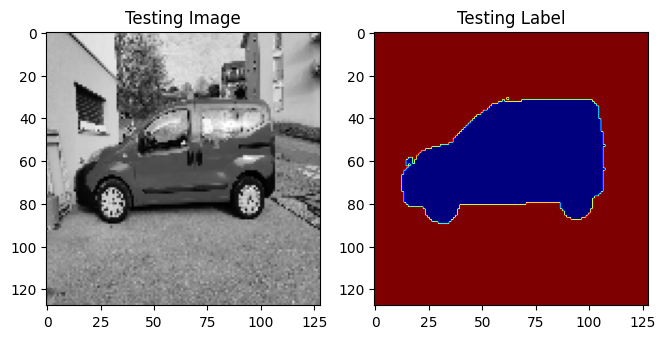

In [66]:
from keras.utils import to_categorical
train_masks_cat = to_categorical(y_train, num_classes=n_classes)
y_train_cat = train_masks_cat.reshape((y_train.shape[0], y_train.shape[1], y_train.shape[2], n_classes))

test_masks_cat = to_categorical(y_test, num_classes=n_classes)
y_test_cat = test_masks_cat.reshape((y_test.shape[0], y_test.shape[1], y_test.shape[2], n_classes))
print(y_train.shape)
print(y_train_cat.shape)

#Stampa la figura
test_img_number = 0
test_img = X_train[test_img_number]
ground_truth=train_masks_cat[test_img_number] #CREDO SIA X_TEST QUI!!
test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img_norm, 0)


plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='jet')

In [38]:
# Building Unet by dividing encoder and decoder into blocks

from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras.optimizers import Adam
from keras.layers import Activation, MaxPool2D, Concatenate


def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)   #Not in the original network. 
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)  #Not in the original network
    x = Activation("relu")(x)

    return x

#Encoder block: Conv block followed by maxpooling


def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p  
#Decoder block
#skip features gets input from encoder for concatenation

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

#Build Unet using the blocks
def build_unet(input_shape, n_classes):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024) #Bridge

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    if n_classes == 1:  #Binary
      activation = 'sigmoid'
    else:
      activation = 'softmax'

    outputs = Conv2D(n_classes, 1, padding="same", activation=activation)(d4)  #Change the activation based on n_classes
    print(activation)

    model = Model(inputs, outputs, name="U-Net")
    return model 


In [39]:
IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH  = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]
input_shape = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)
print(input_shape)

(128, 128, 1)


In [77]:
model = build_unet(input_shape, n_classes=n_classes)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

softmax
Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_57 (Conv2D)             (None, 128, 128, 64  640         ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_54 (BatchN  (None, 128, 128, 64  256        ['conv2d_57[0][0]']              
 ormalization)                  )                                                     

In [78]:
print(X_train.shape)
print(X_test.shape)
print(y_train_cat.shape)
print(y_test_cat.shape)

(168, 128, 128, 1)
(43, 128, 128, 1)
(168, 128, 128, 5)
(43, 128, 128, 5)


In [41]:
callbacks =[keras.callbacks.EarlyStopping(monitor="val_loss", patience=3)]
history = model.fit(X_train, y_train_cat, 
                    batch_size = 16, 
                    verbose=1, 
                    epochs=25, 
                    validation_data=(X_test, y_test_cat), 
                    callbacks=callbacks,
                    shuffle=False)

Epoch 1/25
11/11 [==============================] - 118s 9s/step - loss: 1.4245 - accuracy: 0.4978 - val_loss: 284.8283 - val_accuracy: 0.0556
Epoch 2/25
11/11 [==============================] - 111s 10s/step - loss: 0.7053 - accuracy: 0.8104 - val_loss: 449.5062 - val_accuracy: 0.1471
Epoch 3/25
11/11 [==============================] - 103s 9s/step - loss: 0.5156 - accuracy: 0.8542 - val_loss: 199.9825 - val_accuracy: 0.0571
Epoch 4/25
11/11 [==============================] - 104s 9s/step - loss: 0.4397 - accuracy: 0.8662 - val_loss: 84.2502 - val_accuracy: 0.2513
Epoch 5/25
11/11 [==============================] - 109s 10s/step - loss: 0.3807 - accuracy: 0.8766 - val_loss: 24.9930 - val_accuracy: 0.2788
Epoch 6/25
11/11 [==============================] - 107s 10s/step - loss: 0.3242 - accuracy: 0.8929 - val_loss: 3.1803 - val_accuracy: 0.3141
Epoch 7/25
11/11 [==============================] - 108s 10s/step - loss: 0.2931 - accuracy: 0.9024 - val_loss: 1.6164 - val_accuracy: 0.5629
E

In [42]:
model.save(os.path.join("..",'UNet6_25_epochs.hdf5'))

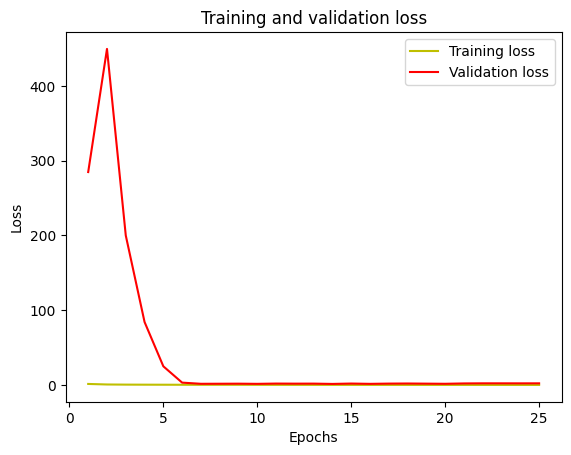

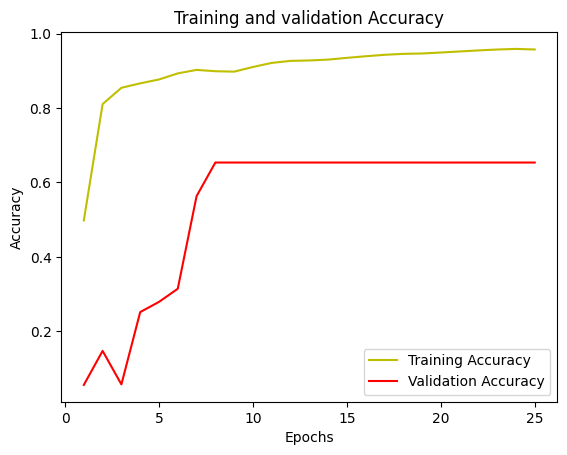

In [43]:
###
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [75]:

#Load previously saved model
from keras.models import load_model
path = os.path.join("..", "UNet6_5_epochs.hdf5")
model = load_model(path, compile=False)
#model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [70]:
y_pred=model.predict(X_test)
y_pred.shape

2/2 [==============================] - 20s 7s/step


(43, 128, 128, 5)

In [47]:
y_pred_argmax=np.argmax(y_pred, axis=3)
y_pred_argmax.shape

(43, 128, 128)

In [76]:
### Fit and Evaluate the model
score = model.evaluate(X_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

ValueError: in user code:

    File "c:\Users\Lucia\Desktop\Università\Deep Learning\jupyter\.env\lib\site-packages\keras\engine\training.py", line 1727, in test_function  *
        return step_function(self, iterator)
    File "c:\Users\Lucia\Desktop\Università\Deep Learning\jupyter\.env\lib\site-packages\keras\engine\training.py", line 1713, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\Lucia\Desktop\Università\Deep Learning\jupyter\.env\lib\site-packages\keras\engine\training.py", line 1701, in run_step  **
        outputs = model.test_step(data)
    File "c:\Users\Lucia\Desktop\Università\Deep Learning\jupyter\.env\lib\site-packages\keras\engine\training.py", line 1667, in test_step
        self.compute_loss(x, y, y_pred, sample_weight)
    File "c:\Users\Lucia\Desktop\Università\Deep Learning\jupyter\.env\lib\site-packages\keras\engine\training.py", line 1052, in compute_loss
        return self.compiled_loss(
    File "c:\Users\Lucia\Desktop\Università\Deep Learning\jupyter\.env\lib\site-packages\keras\engine\compile_utils.py", line 265, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "c:\Users\Lucia\Desktop\Università\Deep Learning\jupyter\.env\lib\site-packages\keras\losses.py", line 152, in __call__
        losses = call_fn(y_true, y_pred)
    File "c:\Users\Lucia\Desktop\Università\Deep Learning\jupyter\.env\lib\site-packages\keras\losses.py", line 272, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "c:\Users\Lucia\Desktop\Università\Deep Learning\jupyter\.env\lib\site-packages\keras\losses.py", line 1990, in categorical_crossentropy
        return backend.categorical_crossentropy(
    File "c:\Users\Lucia\Desktop\Università\Deep Learning\jupyter\.env\lib\site-packages\keras\backend.py", line 5529, in categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)

    ValueError: Shapes (None, 128, 128, 1) and (None, 128, 128, 5) are incompatible


1/1 [==============================] - 0s 432ms/step


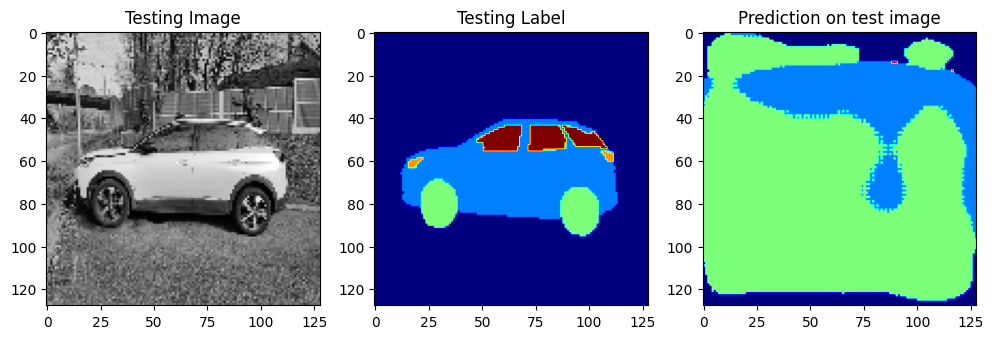

In [74]:
import random
test_img_number = random.randint(0, len(X_test)-1)
test_img = X_test[test_img_number]
ground_truth=y_test[test_img_number]
test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img_norm, 0)
prediction = (model.predict(test_img_input))
predicted_img=np.argmax(prediction, axis=3)[0,:,:]


plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='jet')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img, cmap='jet')
plt.show()